In [102]:
from datetime import datetime

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np
from statsmodels.tsa.deterministic import DeterministicProcess
import holidays

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2.5)
sns.set_style("ticks")

In [103]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_weekday", "post_month", "post_day", "post_year", "release_post", 
         "days_since_previous_release"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "day", "month"]])
df = df[df["release_post"] == True].copy()

In [104]:
df.head()

,post_weekday,post_month,day,year,release_post,days_since_previous_release,month,date
id,,,,,,,,
183,Friday,February,17,2017,True,0.0,2,2017-02-17
197,Sunday,February,26,2017,True,9.0,2,2017-02-26
109,Saturday,March,18,2017,True,20.0,3,2017-03-18
57,Friday,March,24,2017,True,6.0,3,2017-03-24
196,Thursday,March,30,2017,True,6.0,3,2017-03-30


In [105]:
years = set(df["year"])
nj_holidays = holidays.UnitedStates(state="NJ", years=years)
nj_holidays.append({"{}-03-17".format(y) : "St. Patrick's Day" for y in years})
nj_holidays.append({"{}-02-14".format(y) : "Valentine's Day" for y in years})

In [106]:
df = pandas.get_dummies(df, columns=["post_weekday"], prefix="WD")

In [107]:
df = df.groupby(["month", "year"]).agg(
    {c : ("mean" if c == "days_since_previous_release" else "sum") for c in df.columns 
     if c.startswith("WD_") or c == "release_post" or c == "days_since_previous_release"}).reset_index().rename(
    columns={"release_post" : "number_of_releases", "days_since_previous_release" : "avg_days_between_releases"})
df["day"] = 1
df["date"] = pandas.to_datetime(df[["year", "day", "month"]])
df = df.set_index("date")
df.index = df.index.to_period("M")

In [108]:
df["holidays"] = df.apply(
    lambda x : len([h for h in nj_holidays if h.month == x["month"] and h.year == x["year"]]), axis=1)

In [109]:
del df["month"]
del df["day"]
del df["year"]
df = df.sort_index()
df.head()

,number_of_releases,avg_days_between_releases,WD_Friday,WD_Monday,WD_Saturday,WD_Sunday,WD_Thursday,WD_Tuesday,WD_Wednesday,holidays
date,,,,,,,,,,
2017-02,2,4.500000,1,0,0,1,0,0,0,4
2017-03,3,10.666667,1,0,1,0,1,0,0,1
2017-04,4,5.250000,1,0,2,1,0,0,0,1
2017-05,3,9.333333,2,0,0,1,0,0,0,1
2017-06,5,7.000000,3,0,2,0,0,0,0,0


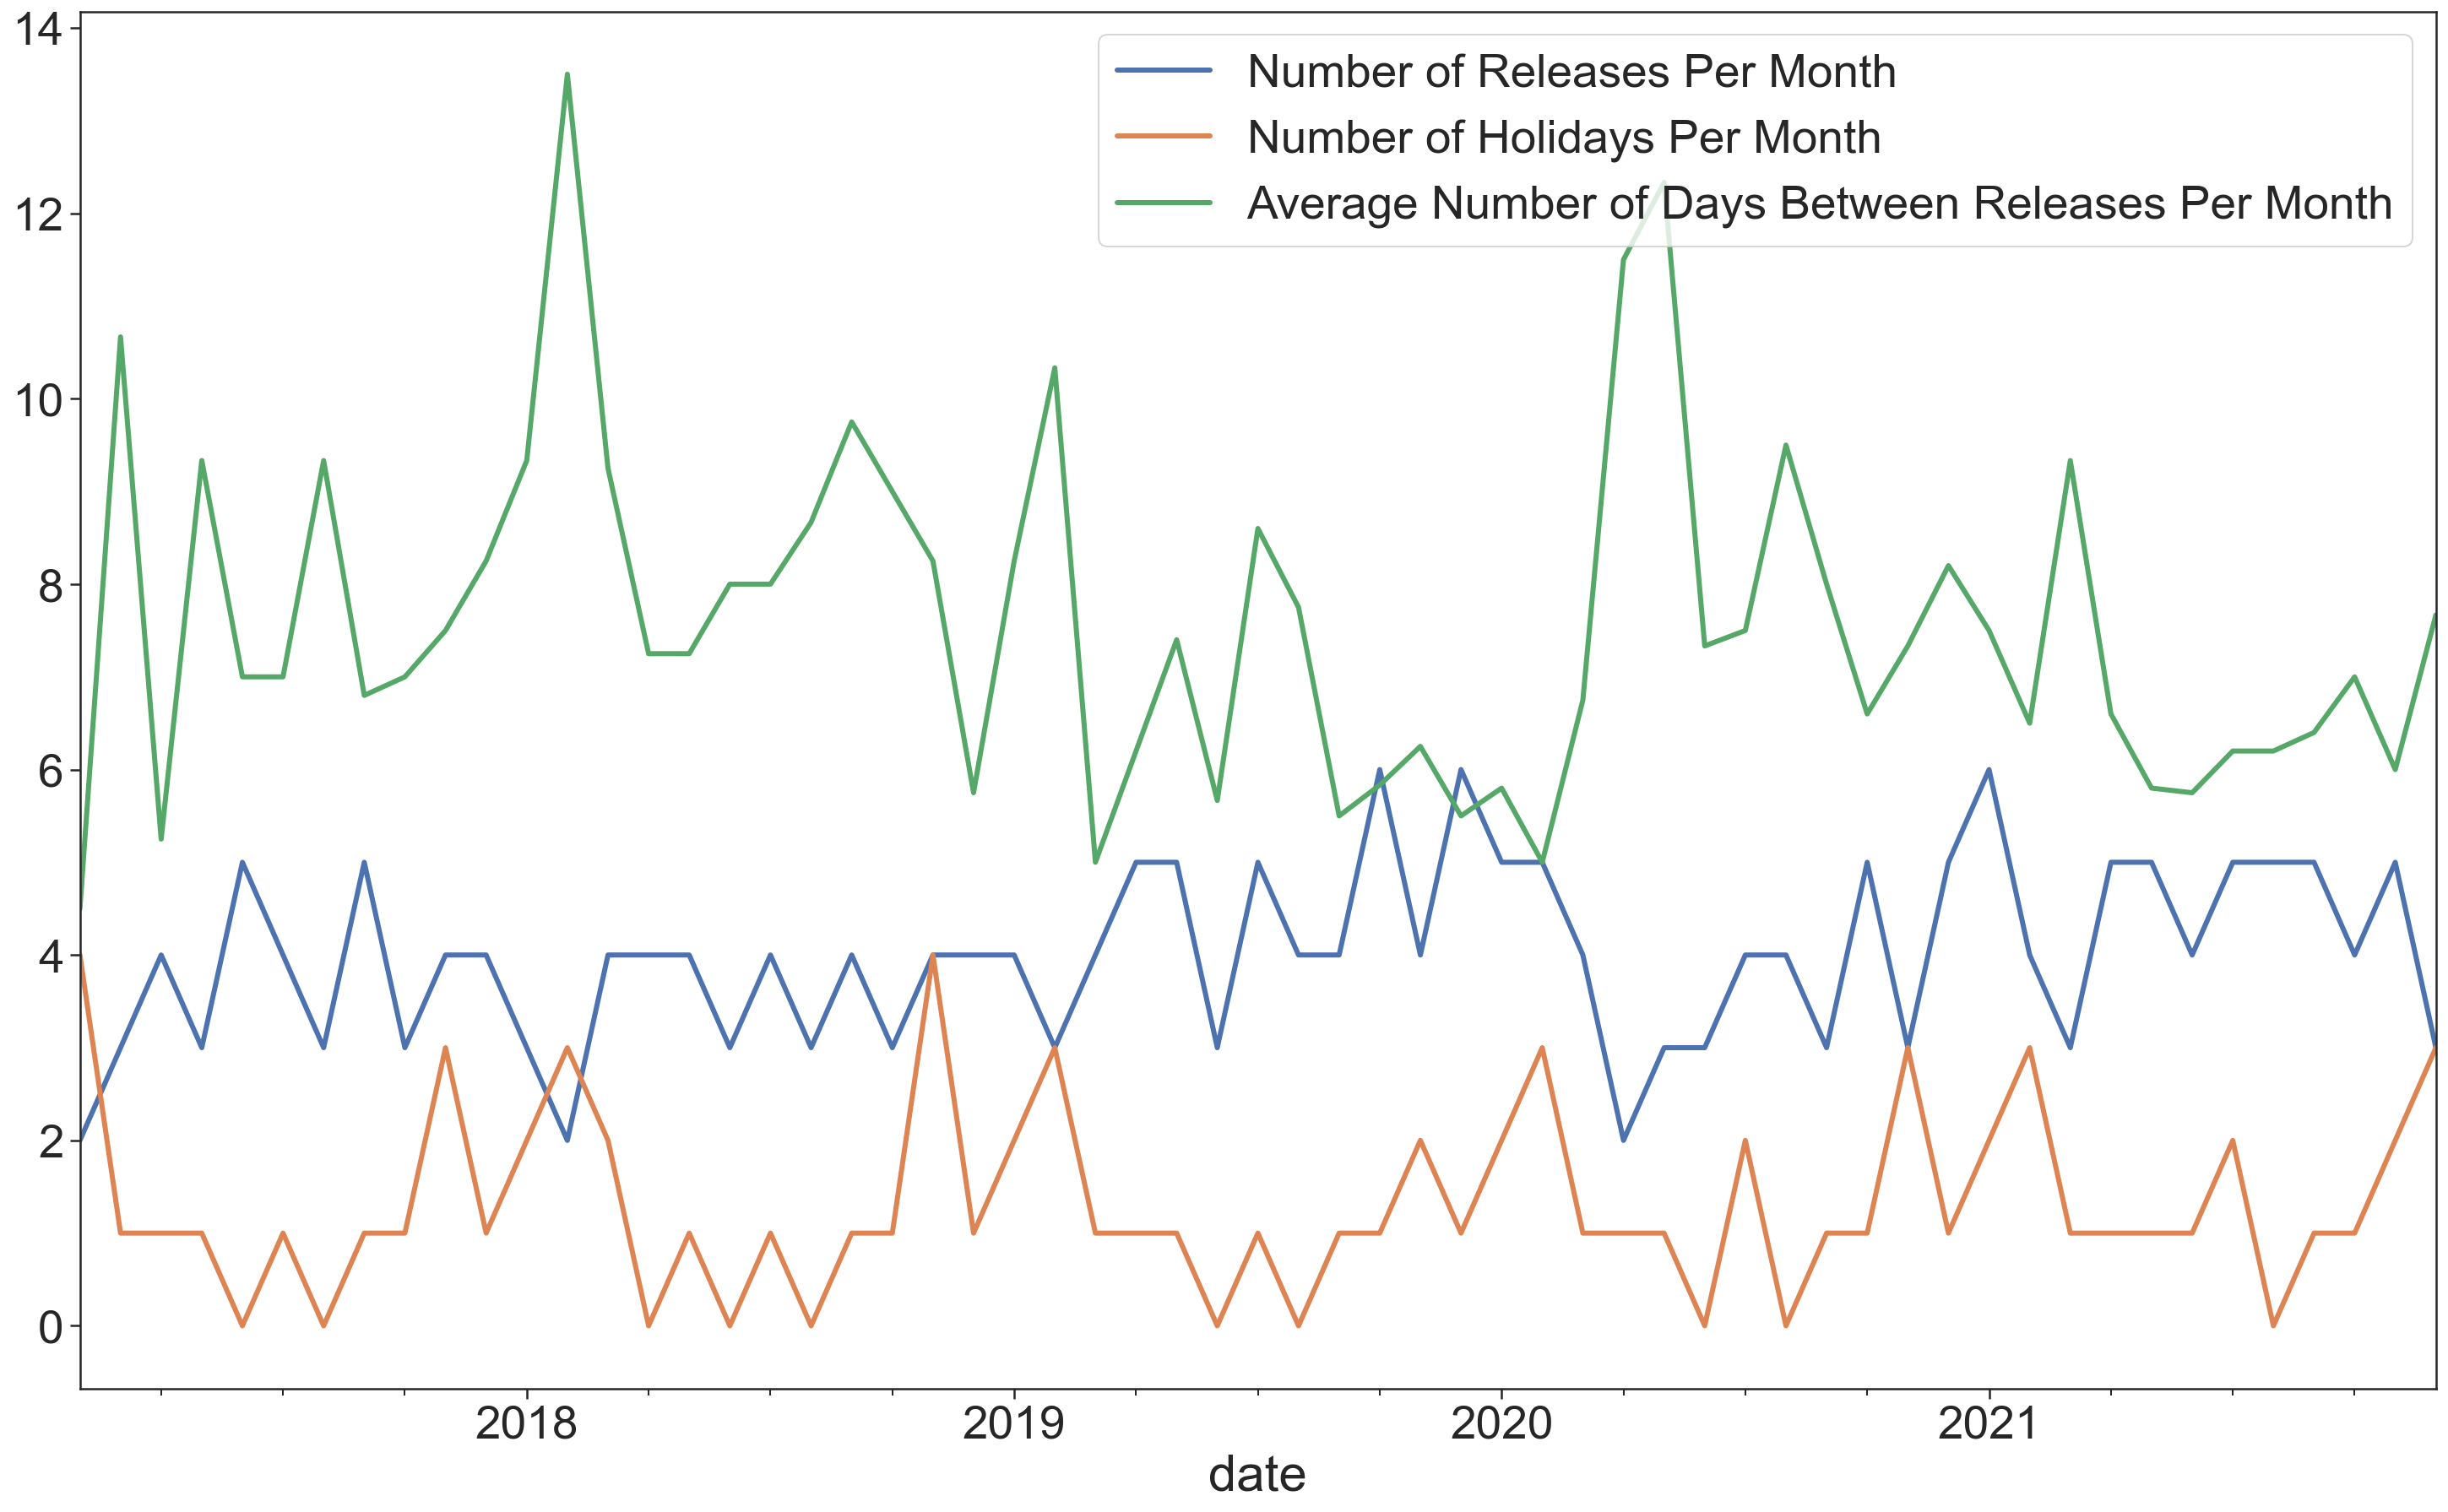

In [110]:
ax = df["number_of_releases"].plot(linewidth=3)
df["holidays"].plot(ax=ax, linewidth=3)
df["avg_days_between_releases"].plot(ax=ax, linewidth=3)
ax.legend(["Number of Releases Per Month", "Number of Holidays Per Month",
           "Average Number of Days Between Releases Per Month"])
plt.show()

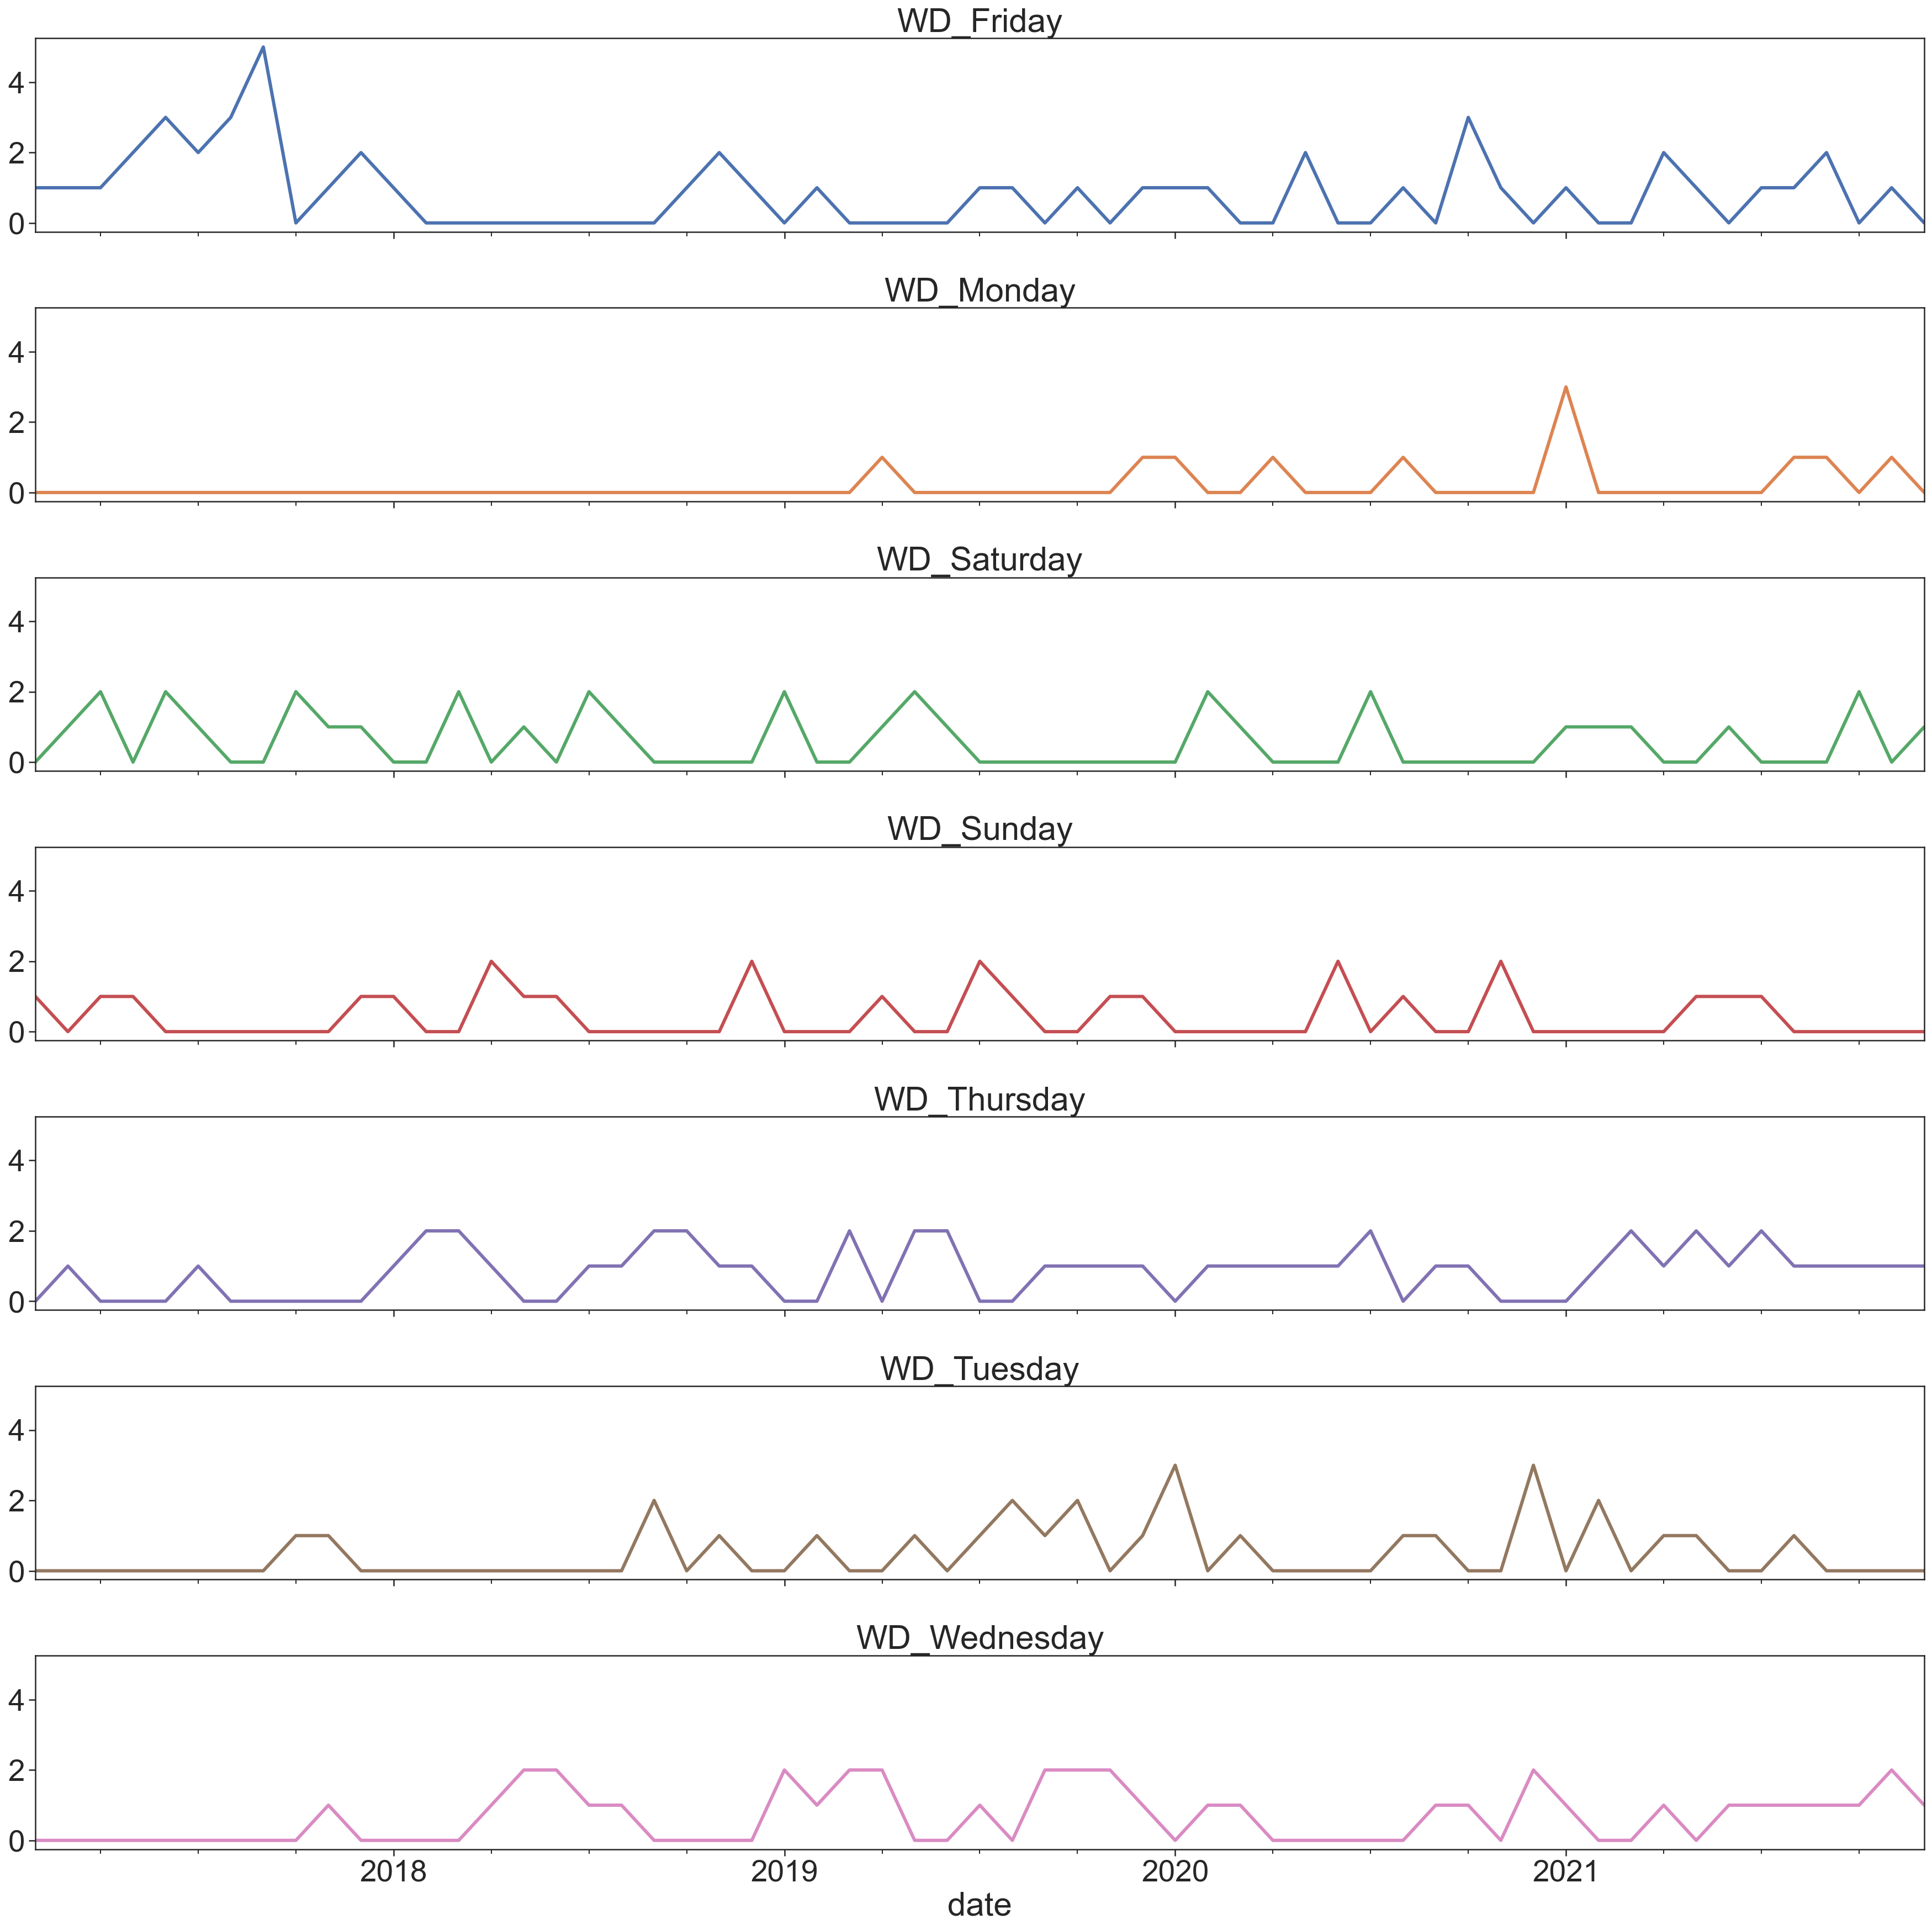

In [111]:
(fig, axs) = plt.subplots(7, sharex=True, sharey=True)
fig.set_size_inches(25, 25)
palette = sns.color_palette(None, 7)
for (i, col) in enumerate([c for c in df.columns if c.startswith("WD_")]):
    df[col].plot(ax=axs[i], linewidth=3, title=col, color=palette[i])
plt.tight_layout()

<AxesSubplot:xlabel='date'>

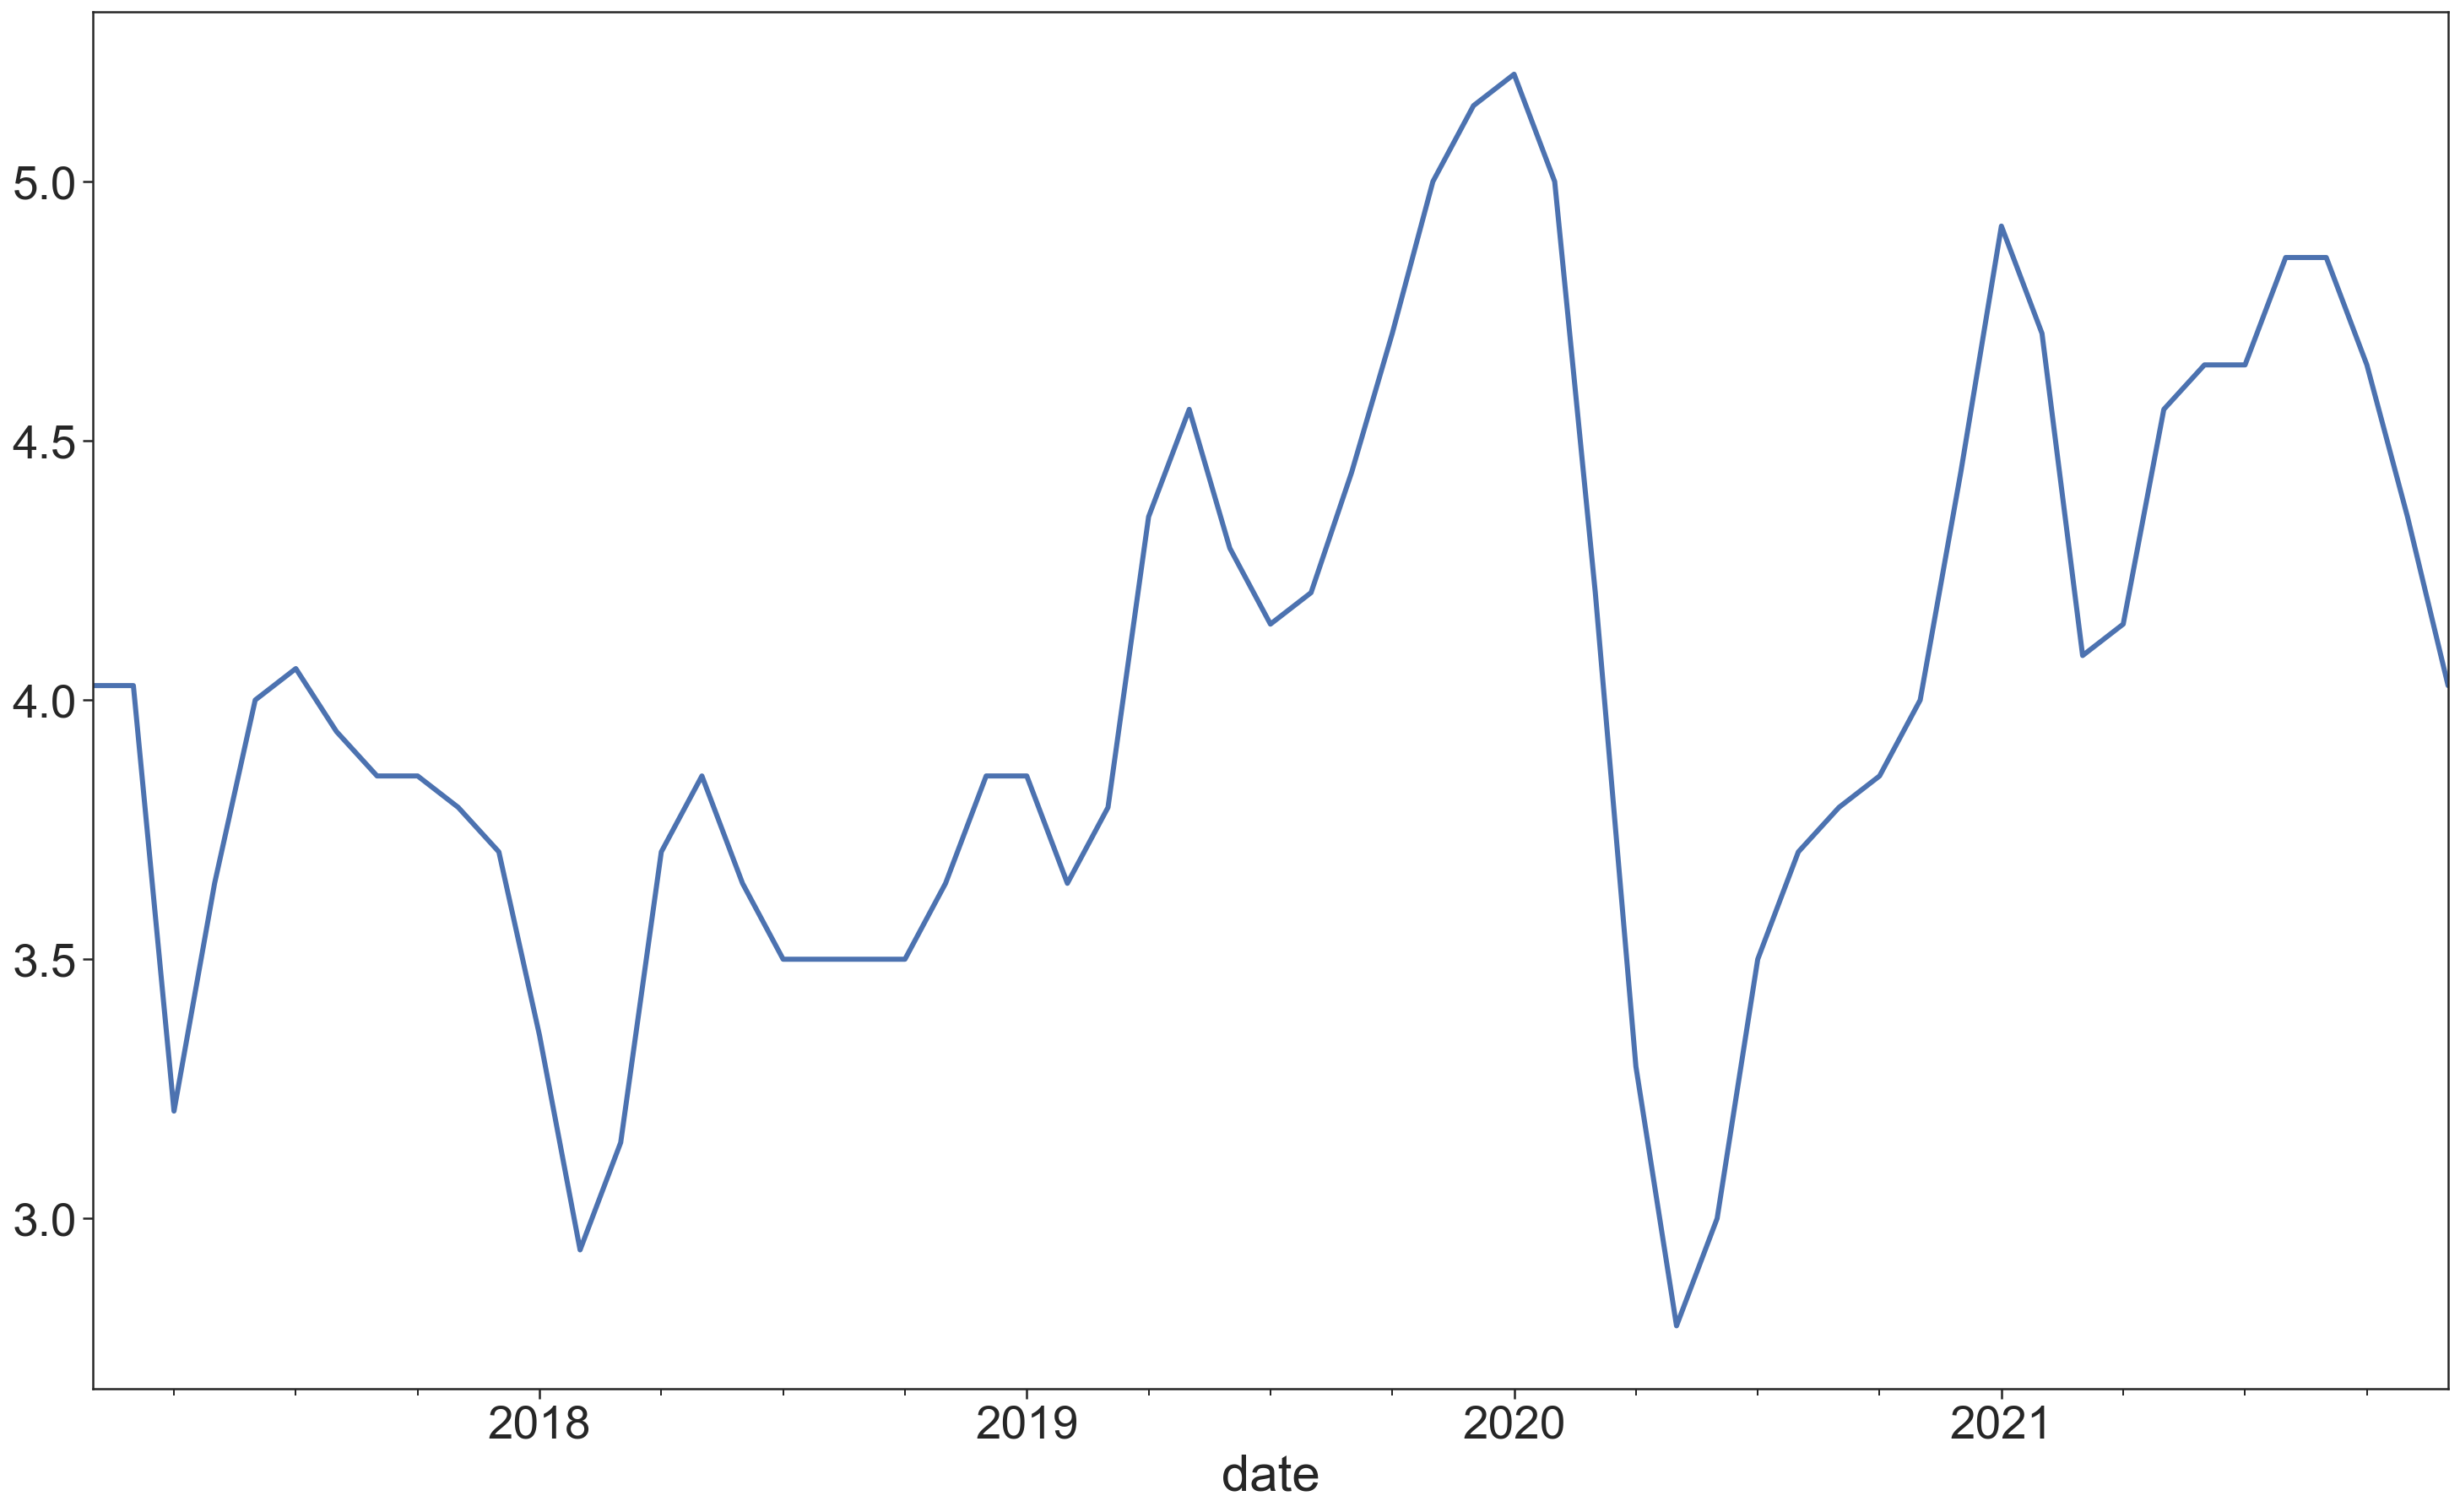

In [112]:
temp = df.rolling(window=4, center=True, win_type="cosine").mean()[["number_of_releases"]]
temp = temp.rename(columns={"number_of_releases" : "quarterly_cosine"})
df = df.join(temp)
df["quarterly_cosine"] = df["quarterly_cosine"].fillna(df["quarterly_cosine"].mean())
df["quarterly_cosine"].plot(linewidth=3)

In [113]:
df["releases_lag_1"] = df["number_of_releases"].shift(1).fillna(0)

In [114]:
df["month"] = df.index.month
df = pandas.get_dummies(df, columns=["month"], prefix="month")

In [115]:
# dp = DeterministicProcess(df.index, order=2, seasonal=False, fourier=1, drop=True)
# df = df.join(dp.in_sample())

In [116]:
df[[c for c in df.columns if not c.startswith("WD_") and not c.startswith("month_")]].corr()[
    ["number_of_releases"]]

,number_of_releases
number_of_releases,1.000000
avg_days_between_releases,-0.525587
holidays,-0.117366
quarterly_cosine,0.644333
releases_lag_1,0.225009


In [117]:
df[[c for c in df.columns if c.startswith("WD_") or c == "number_of_releases"]].corr()[["number_of_releases"]]

,number_of_releases
number_of_releases,1.000000
WD_Friday,0.257552
WD_Monday,0.390184
WD_Saturday,0.059232
WD_Sunday,-0.043029
WD_Thursday,-0.053148
WD_Tuesday,0.331324
WD_Wednesday,0.366441


In [118]:
df[[c for c in df.columns if c.startswith("month_") or c == "number_of_releases"]].corr()[["number_of_releases"]]

,number_of_releases
number_of_releases,1.000000
month_1,0.144414
month_2,-0.246825
month_3,-0.120741
month_4,0.005343
month_5,0.005343
month_6,-0.120741
month_7,0.131426
month_8,-0.057699
month_9,0.068384


In [119]:
len(df) * 0.85

50.15

In [120]:
train_df = df[0:50].copy()
len(train_df)

50

In [121]:
test_df = df[50:].copy()
len(test_df)

9

In [122]:
df.columns

Index(['number_of_releases', 'avg_days_between_releases', 'WD_Friday',
       'WD_Monday', 'WD_Saturday', 'WD_Sunday', 'WD_Thursday', 'WD_Tuesday',
       'WD_Wednesday', 'holidays', 'quarterly_cosine', 'releases_lag_1',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [145]:
reg_features = ['quarterly_cosine', 'releases_lag_1']

In [146]:
resid_model_features = [c for c in df.columns if c.startswith("WD_") or c.startswith("month_")]

---

In [147]:
reg = GridSearchCV(estimator=ElasticNet(random_state=1024),
                   scoring="neg_mean_absolute_percentage_error",
                   n_jobs=-1, refit=True, cv=3,
                   param_grid={"alpha" : [1, 1.5, 2, 2.5, 3],
                               "l1_ratio" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]})
reg.fit(train_df[reg_features], train_df["number_of_releases"])

GridSearchCV(cv=3, estimator=ElasticNet(random_state=1024), n_jobs=-1,
             param_grid={'alpha': [1, 1.5, 2, 2.5, 3],
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1]},
             scoring='neg_mean_absolute_percentage_error')

In [148]:
reg.best_score_

-0.2184849611285562

In [149]:
test_df["predicted"] = reg.predict(test_df[reg_features]).round(0)

In [150]:
mape(test_df["number_of_releases"], test_df["predicted"])

0.1703703703703704

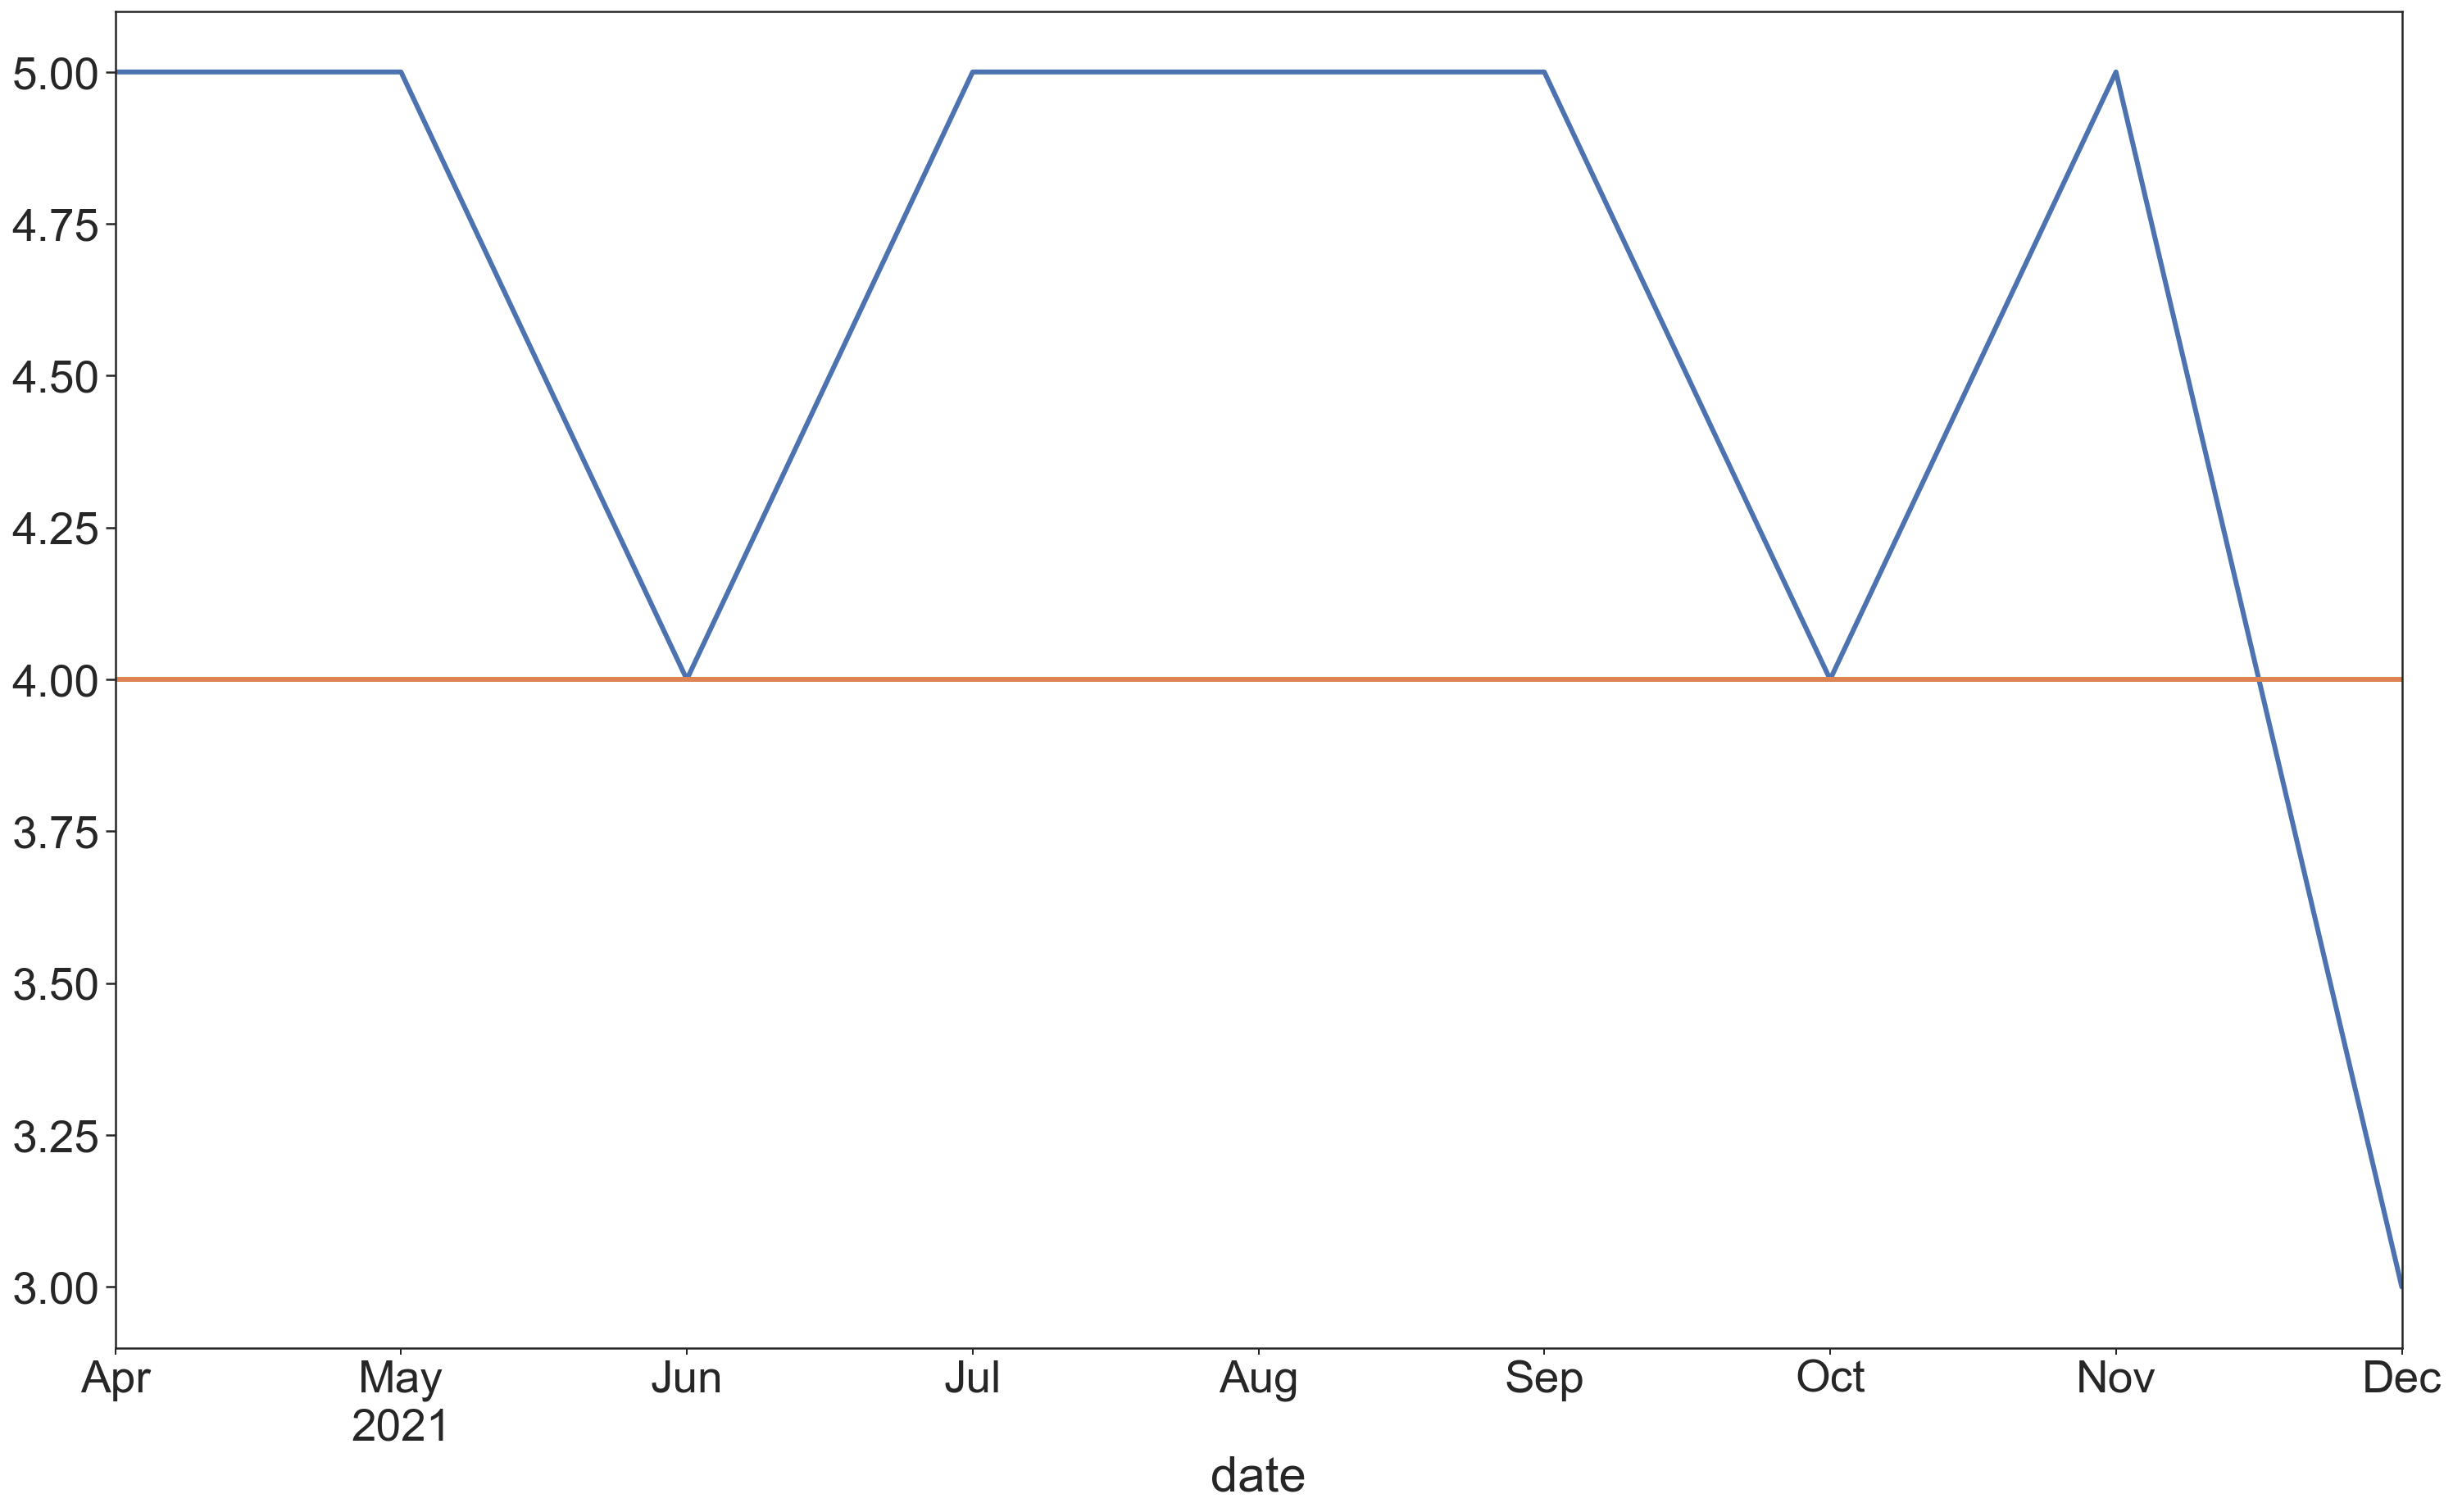

In [151]:
ax = test_df["number_of_releases"].plot(linewidth=3)
test_df["predicted"].plot(ax=ax, linewidth=3)
plt.show()

In [152]:
list(zip(reg_features, reg.best_estimator_.coef_))

[('quarterly_cosine', 0.18794865373304215),
 ('releases_lag_1', 0.034748308514022115)]